In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import random
import numpy as np
import os 

from IPython.display import Audio
from torchaudio.utils import download_asset
from custom_transforms import TimeShiftRange, IRAugmentation

In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [3]:
waveform, sample_rate = torchaudio.load('data/TAU-urban-acoustic-scenes-2022-mobile-development/audio/airport-barcelona-0-2-4-s6.wav')

print(waveform)
print(waveform.shape)
print(sample_rate)



tensor([[ 0.0280,  0.0287,  0.0281,  ..., -0.0048, -0.0081, -0.0114]])
torch.Size([1, 44100])
44100


In [4]:
dirs, sample_rate_dir = torchaudio.load('dirs/American_R331.wav')

print(dirs)
print(dirs.shape)
print(sample_rate_dir)


tensor([[4.4227e-05, 4.1127e-05, 6.4492e-05,  ..., 5.4836e-06, 2.3842e-07,
         7.3910e-06]])
torch.Size([1, 16455])
44100


In [5]:
#Modify dirs to match shape [1,44100]
if dirs.shape[1] < 44099:
    dirs2 = torch.cat((dirs, torch.zeros(1,44100-dirs.shape[1])),1)
print(dirs2.shape)
print(dirs2)


torch.Size([1, 44100])
tensor([[4.4227e-05, 4.1127e-05, 6.4492e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [6]:
Audio(dirs2, rate=sample_rate_dir)

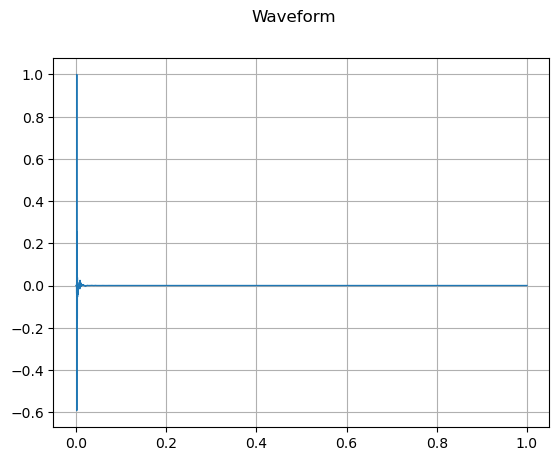

In [7]:
plot_waveform(dirs2, sample_rate_dir, title="Waveform")

In [8]:
waveform3, sample_rate3 = torchaudio.load('data/TAU-urban-acoustic-scenes-2022-mobile-development/audio/airport-barcelona-0-2-4-s5.wav') 
sample_noise = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

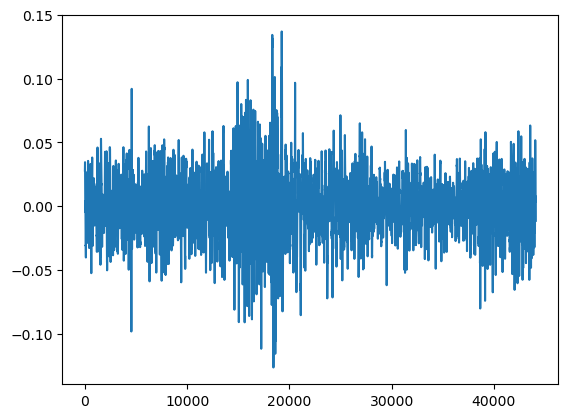

In [9]:
#PLot
plt.plot(waveform.t().numpy())
plt.show()

In [10]:
noise, n_sample_rate = torchaudio.load(sample_noise)

# Trim the noise to match the length of the waveform
noise = noise[:, :waveform.shape[1]]

# If the noise is shorter than the waveform, repeat it
if noise.shape[1] < waveform.shape[1]:
    num_repeats = waveform.shape[1] // noise.shape[1]
    remainder = waveform.shape[1] % noise.shape[1]
    noise = torch.cat([noise] * num_repeats, dim=1)
    noise = torch.cat([noise, noise[:, :remainder]], dim=1)



snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(waveform, noise, snr_dbs)

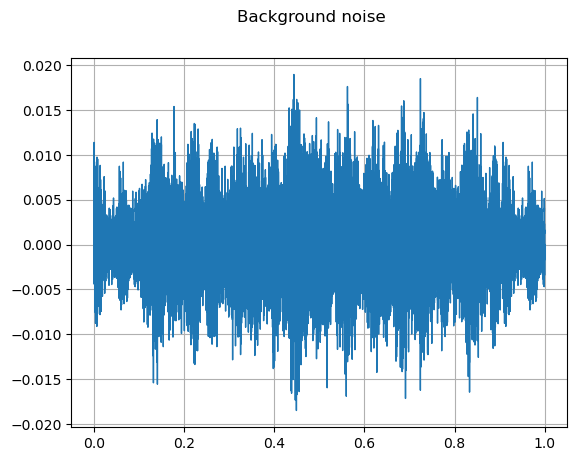

In [11]:
plot_waveform(noise, sample_rate, title="Background noise")

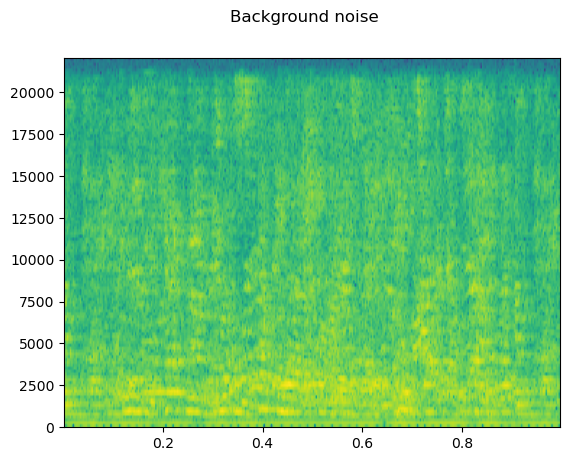

In [12]:
plot_specgram(noise, sample_rate, title="Background noise")

In [13]:
Audio(waveform, rate=sample_rate)

In [14]:
Audio(noisy_speeches, rate=sample_rate)

tensor([[ 0.0000e+00,  6.5005e-07,  1.2760e-06,  ..., -4.8462e-03,
         -8.0801e-03, -1.1417e-02]])


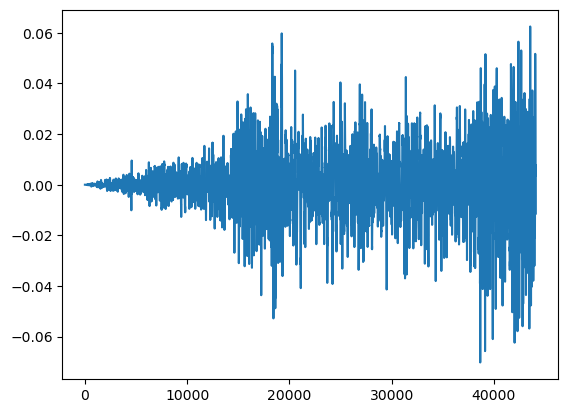

In [15]:
transform = T.Fade(fade_in_len=sample_rate, fade_shape='linear')
faded = transform(waveform)
print(faded)
plt.plot(faded.t().numpy())
plt.show()
Audio(waveform, rate=sample_rate)


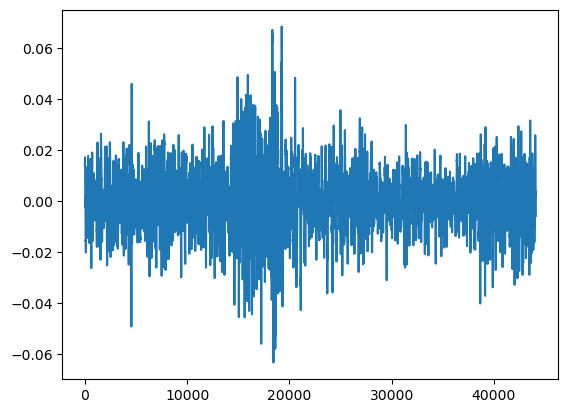

In [16]:
transform = T.Vol(gain=0.5)
transformed = transform(waveform)
plt.plot(transformed.t().numpy())
plt.show()
Audio(transformed, rate=sample_rate)

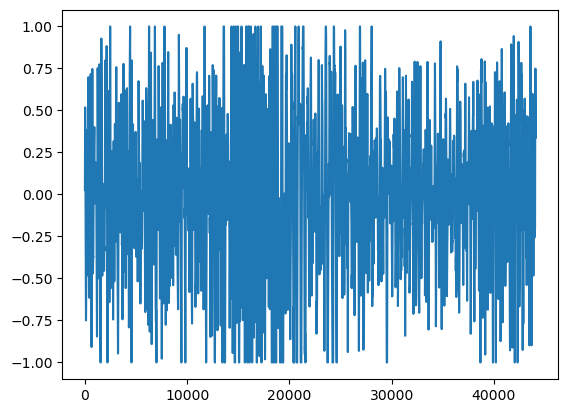

In [17]:
transform = T.Deemphasis()
transformed = transform(waveform)
plt.plot(transformed.t().numpy())
plt.show()
Audio(transformed, rate=sample_rate)

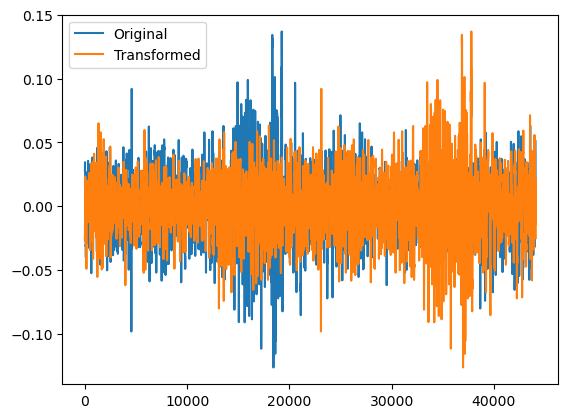

In [18]:
#Test TimeShiftRange with waveform
transform = TimeShiftRange(sample_rate=sample_rate, max_shift=5)
transformed = transform(waveform)
#Plot the original and transformed waveform
plt.plot(waveform.t().numpy(), label='Original')
plt.plot(transformed.t().numpy(), label='Transformed')
plt.legend()
plt.show()



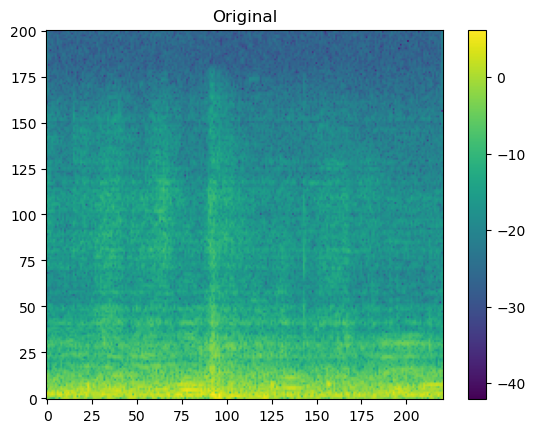

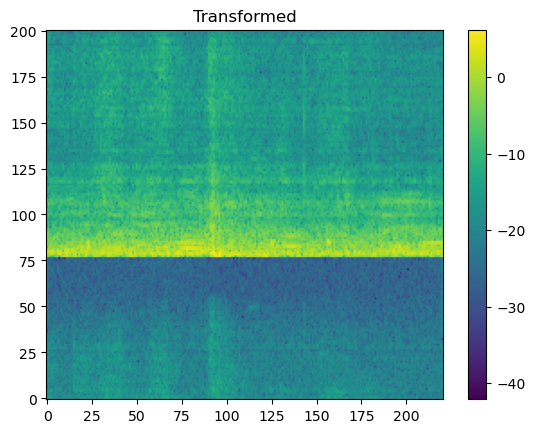

In [19]:
#Transform waveform to spectrogram and apply TimeShiftRange
transform = T.Spectrogram()
spectrogram = transform(waveform)
transform = TimeShiftRange(sample_rate=sample_rate, max_shift=5)
transformed = transform(spectrogram)
#Plot the original and transformed spectrogram
plt.figure()
plt.imshow(spectrogram.log2()[0,:,:].numpy(), aspect='auto', origin='lower')
plt.title('Original')
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(transformed.log2()[0,:,:].numpy(), aspect='auto', origin='lower')
plt.title('Transformed')
plt.colorbar()
plt.show()


In [20]:
import torch
from scipy.signal import convolve
#Flip the impulse response
impulse_response = dirs2.flip(1)
impulse_response2 = dirs2
#Flip the impulse response



ir_transform = IRAugmentation(impulse_response)
transformed_waveform = ir_transform(waveform) 




x2 = convolve(waveform, impulse_response2, mode='full')
x3 = x2[:, :waveform.shape[1]]
print(x3)
print(x3.shape)

#print(torch.allclose(transformed_waveform[0], torch.tensor(x2)))


plot_waveform(transformed_waveform, sample_rate, title="Transformed Torch")
#Plot x2 array





#plt.show() 


TypeError: __init__() takes 1 positional argument but 2 were given

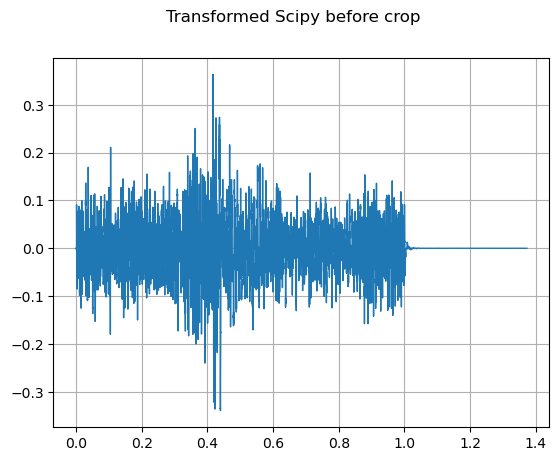

In [ ]:
plot_waveform(torch.tensor(x2), sample_rate, title="Transformed Scipy before crop")
plt.show()

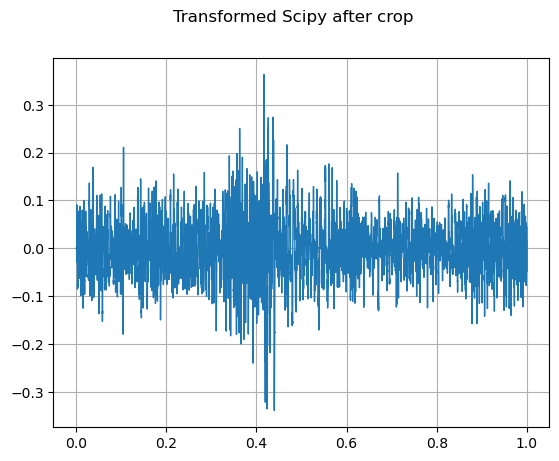

In [ ]:
plot_waveform(torch.tensor(x3), sample_rate, title="Transformed Scipy after crop")
plt.show()

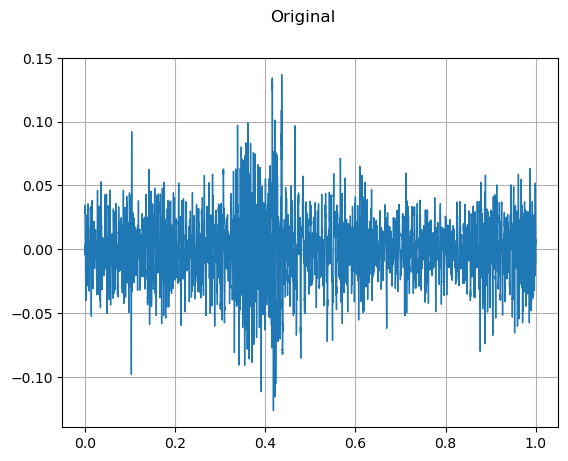

In [ ]:
plot_waveform(waveform, sample_rate, title="Original")

In [ ]:
#Heard the original and transformed waveforms
Audio(waveform, rate=sample_rate)


In [ ]:
Audio(transformed_waveform, rate=sample_rate) #Torch

In [ ]:
Audio(x2, rate=sample_rate) #Scipy

In [ ]:
#get length of dirs folder
dirs = os.listdir('dirs')
idx = np.random.randint(0, len(dirs))

#Load the impulse response
impulse_response, sample_rate = torchaudio.load(f'dirs/{dirs[idx]}')

In [ ]:
print(dirs[idx])

dir, sr_dir = torchaudio.load(f'dirs/{dirs[idx]}')



IR_ResloDynamic.wav


In [21]:
ira_transform = IRAugmentation()
transformed_waveform = ira_transform(waveform)


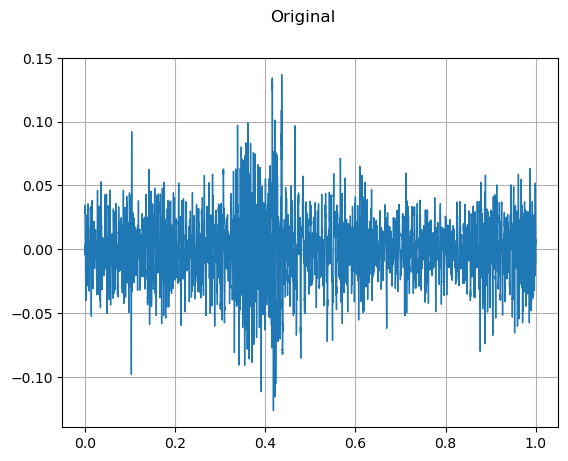

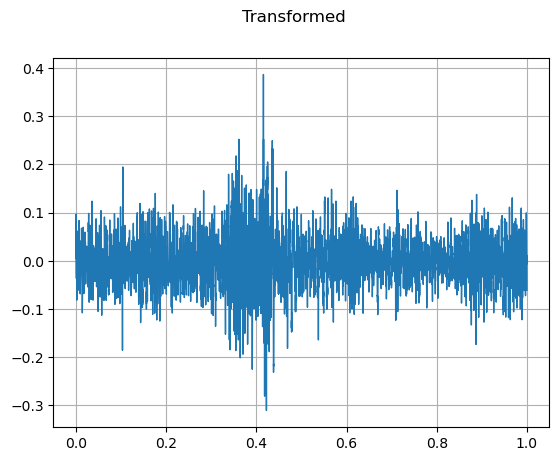

In [22]:
#Plot the original and transformed waveform
plot_waveform(waveform, sample_rate, title="Original")
plot_waveform(transformed_waveform, sample_rate, title="Transformed")